In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

In [7]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 1e-2
batch_size = None

def exp(n_size, each_ot, design):
    np.random.seed()
    init_n = np.zeros(n_size) + 2
    init_film = EqOTFilm(init_n, each_ot * n_size, substrate=1.5)

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        design.target_specs, 
        max_steps=500, 
        alpha=alpha, # 0.1
        record=True, 
        show=True, 
        n_min=n_min, # 1.5
        n_max=n_max, # 2.5
        wl_batch_size=batch_size # 200 / 500
    )

    films, losses = adam_optimizer.optimize()
    return films, losses
    return calculate_RMS_f_spec(init_film, design.target_specs), init_film



In [ ]:
each_ots = np.array([i for i in 10 ** np.linspace(-1, 3, 50)])
n_sizes = np.array([int(i) for i in 10 ** np.linspace(0, 4.5, 50)])

# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

design = make_three_line_filter_design() # 1 / wl_max - 1 / wl_min = 



films_arr_rep, best_loss_arr_rep, best_film_arr_rep = [], [], []
for rep in range(reps):
    films_arr_rep.append([])
    best_loss_arr_rep.append([])
    best_film_arr_rep.append([])
    for i, ot in enumerate(each_ots):
        films_arr_rep[-1].append([])
        best_loss_arr_rep[-1].append([])
        best_film_arr_rep[-1].append([])
        for j, n_size in enumerate(n_sizes):
            print((i + j / n_sizes.shape[0]) / each_ots.shape[0])
            best_loss, best_film = exp(n_size, ot, design)
            films_arr_rep[-1][-1].append([])
            best_loss_arr_rep[-1][-1].append(best_loss)
            best_film_arr_rep[-1][-1].append(best_film)

save('./raw_result/free_form_params_ot1e-1to1e3_nsize1to1e4.5_log_int', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))

film has no spec. use 1000 nm


Text(0, 0.5, 'gradient')

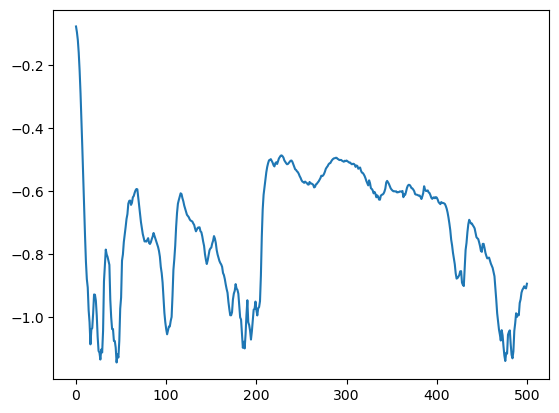

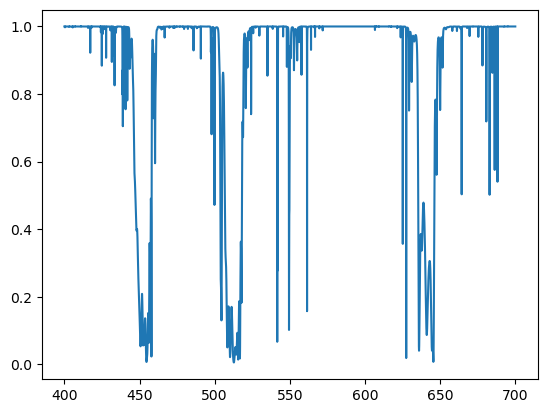

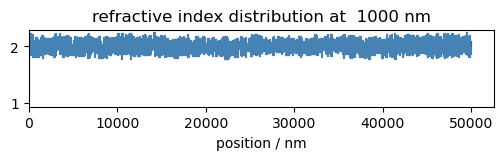

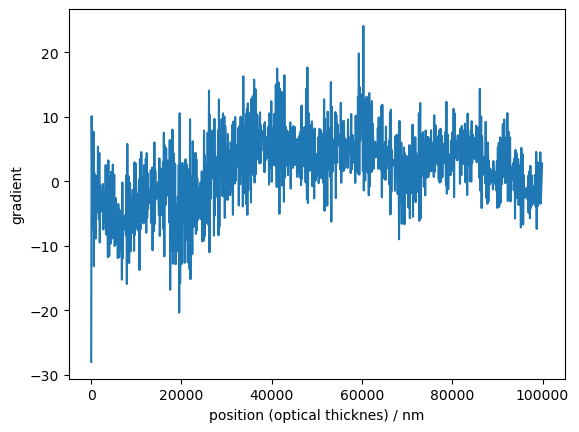

In [13]:
# try init with no high freq
each_ot = 100
n_size = 1000
design = make_three_line_filter_design()
films, losses = exp(n_size, each_ot, design)

fig, ax = plt.subplots(1, 1)
ax.plot(np.log10(losses))

fig, ax = plt.subplots(1, 1)
s = films[-1].get_spec(0., np.linspace(400, 700, 10000))
ax.plot(s.WLS, s.get_R())

plot_layer_thickness(films[45])


optimizer_1 = AdamFreeFormOptimizer(copy.deepcopy(films[10]), design.target_specs, max_steps=1, step_size=0)
optimizer_1()
fig, ax = plt.subplots(1, 1)
ax.plot(100 * np.arange(optimizer_1.g.shape[0]), optimizer_1.g)
ax.set_xlabel('position (optical thicknes) / nm')
ax.set_ylabel('gradient')

In [ ]:
f = best_film_arr_rep[-1][40][30]
wls = np.linspace(300, 900, 500)
plt.plot(wls, f.add_spec_param(0., wls).get_R())
plot_layer_thickness(EqOTFilm(f.get_n()[:40], f.get_optical_thickness(100), '1'))

In [154]:
best_loss_arr_rep, best_film_arr_rep = load('./raw_result/free_form_params_ot1to1000_nsize1to1000_log_int')
best_loss_arr = best_loss_arr_rep[0]

In [ ]:

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(best_loss_arr), 
    extent=[n_sizes[0], n_sizes[-1], each_ots[-1], each_ots[0]], 
    aspect='auto'
)
to_y = lambda x: (np.log10(x) - np.log10(each_ots[0])) * (-each_ots[0] + each_ots[-1]) / (-np.log10(each_ots[0]) + np.log10(each_ots[-1])) + each_ots[0]
to_x = lambda x: (np.log10(x) - np.log10(n_sizes[0])) * (-n_sizes[0] + n_sizes[-1] )/ (-np.log10(n_sizes[0]) + np.log10(n_sizes[-1])) + n_sizes[0]

FT_lim = 1 / (1 / 400 - 1 / 400)
ax.plot([to_x(n_sizes[0]), to_x(n_sizes[-1])], [to_y(FT_lim * 3/ 4), to_y(FT_lim * 3 / 4)], c='red', label='Fourier period limit')
ax.plot([to_x(n_sizes[0]), to_x(n_sizes[-1])], [to_y(FT_lim * 5/ 4), to_y(FT_lim * 5 / 4)], c='red')
ax.invert_yaxis()
ax.set_ylabel('ot of each layer')
ax.set_xlabel('subdivided layer number')

make_ticks = lambda x: np.linspace(x[0], x[-1], x.shape[0] // 10 + 1)
make_tick_labels = lambda x: [f'{s: .1f}' for s in x[::10]] + [f'{x[-1]: .0f}']

ax.set_xticks(ticks=make_ticks(n_sizes), labels=make_tick_labels(n_sizes))
ax.set_yticks(ticks=make_ticks(each_ots), labels=make_tick_labels(each_ots))
# ax.set_ylim(5, None)
# ax.set_xlim(50, None)


ax.legend()


cbar = fig.colorbar(s)
cbar.set_label('log10 loss')

# fig.savefig('./results/design/Fourier/scan_ot_and_layernumber_log.png', dpi=300)